/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Reached terminal state at 1100 evals
Episode 1
Actions chosen: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


Episode took 0.4389307009987533


Reached terminal state at 800 evals
Episode 2
Actions chosen: [19, 19, 19, 19, 19, 19, 19, 19]


Episode took 0.019580035004764795


Reached terminal state at 600 evals
Episode 3
Actions chosen: [19, 19, 19, 19, 19, 19]


Episode took 0.014278495000326075


Reached terminal state at 1300 evals
Episode 4
Actions chosen: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


Episode took 0.03333332100010011


Reached terminal state at 600 evals
Episode 5
Actions chosen: [19, 19, 19, 19, 19, 19]


Episode took 0.0145075060063391


Reached terminal state at 2500 evals
Episode 6
Actions chosen: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


Episode took 0.0619687439975678


Reached terminal state at 1100 evals
Episode 7
Actions chosen: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


Episode took

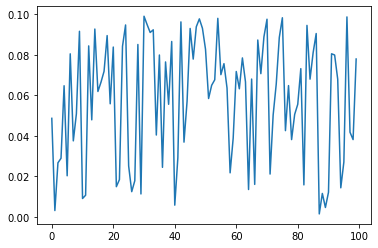

In [1]:
import time
%matplotlib inline
from deep_rl_ga.ga_env import GeneticAlgorithmEnv
from deep_rl_ga.agent import Agent
from deep_rl_ga.memory import Experience, ReplayMemory, extract_tensors
from deep_rl_ga.strategy import (
    NoExplorationStrategy,
)
from deep_rl_ga.network import DQN
from deep_rl_ga.qvalues import QValues

from deap import benchmarks
from deap import tools

import torch
import torch.optim as optim
import torch.nn.functional as F

from itertools import count
import random

import numpy as np

import matplotlib.pyplot as plt
from IPython import display

from deap import creator
from typing import List
import itertools
# import cuml
# import cudf
# import cupy
import datetime
import os
from deep_rl_ga.diversity import (
    Clusterer,
    fitness_max_mean_ratio_diversity,
    fitness_mean_min_ratio_diversity,
    gene_mean_std_diversity,
    gene_mean_unique_ratio_diversity,
    number_of_clusters_diversity,
    selBestPossible,
    selWorstPossible,
)

# Genetic algorithm params
IND_SIZE = 3
LOW_BOUND = -5.12
UP_BOUND = 5.12
FITNESS_FUNCTION = benchmarks.sphere
SEARCH_SPACE_CENTER = np.array([(UP_BOUND - LOW_BOUND / 2) for _ in range(IND_SIZE)])
SEARCH_SPACE_DIAMETER = np.linalg.norm(np.array([UP_BOUND for _ in range(IND_SIZE)]) - np.array([LOW_BOUND for _ in range(IND_SIZE)]))

INITIAL_POPULATION_SIZE = 100

# Crossover + Mutation params
ATTRIBUTE_MUTATION_RATE = 0.3

# Selection params
TOURNAMENT_SIZE = 3
TOP_BEST_SIZE = 25

TOURNAMENT_SIZE_VALUES = [3, 10]
TOP_BEST_SIZE_VALUES = [25]

NUM_TRAP_ACTIONS = 1

MAX_EVALS = 10_000

_NUM_GENERATIONS = MAX_EVALS / INITIAL_POPULATION_SIZE

RANDOM_SEED = 255

random.seed(
    RANDOM_SEED
    )
np.random.seed(
    RANDOM_SEED
    )


ACTIONS_SEL = list(itertools.chain(
    [{'function': selWorstPossible} for _ in range(NUM_TRAP_ACTIONS)],  # fill the population with the WORST individuals - this is the action the network should avoid
    [{'function': tools.selTournament, 'tournsize': tsize} for tsize in TOURNAMENT_SIZE_VALUES],
    # [{'function': tools.selRoulette}],
    # [{'function': tools.selStochasticUniversalSampling}],
    # [{'function': tools.selAutomaticEpsilonLexicase}],
    # [{'function': lambda population, k: tools.selWorst(population, TOP_BEST_SIZE)}],
    # [{'function': selBestPossible, 'top_n': TOP_BEST_SIZE}],  # fill the population with the BEST individuals
    # [{'function': lambda population, k: population}],  # no-op
))

ACTIONS_CX = [
    {'function': tools.cxBlend, 'alpha': UP_BOUND},
    # {'function': tools.cxUniform, 'indpb': 0.4},
    # {'function': tools.cxOrdered},
    # {'function': lambda ind1, ind2: (ind1, ind2)},  # no-op
]

ACTIONS_MU = [
    {'function': tools.mutGaussian, 'mu': 0, 'sigma': UP_BOUND / 2, 'indpb': ATTRIBUTE_MUTATION_RATE},
    # {'function': tools.mutPolynomialBounded, 'eta': 0.3, 'low': LOW_BOUND, 'up': UP_BOUND, 'indpb': ATTRIBUTE_MUTATION_RATE},
    # {'function': tools.mutShuffleIndexes, 'indpb': ATTRIBUTE_MUTATION_RATE},
    # {'function': lambda ind: (ind,)},  # no-op
]

ACTIONS_CXPB = [0.1, 0.3, 0.6]

ACTIONS_MUTPB = [0.05, 0.2, 0.6]


CLUSTERER = Clusterer()

N_CLUSTERS = 10

N_STACKED_STATES = 5

# class RapidsClusteringMethod:
#     def __init__(self, n_clusters, random_state):
#         self.model = cuml.cluster.KMeans(init='k-means||', n_clusters=n_clusters, random_state=random_state)
#
#     def fit_predict(self, X):
#         device_data = cudf.DataFrame(X)
#         return self.model.fit_predict(device_data).to_numpy()

STAT_FUNCTIONS = [
    # ("max_fitness", lambda
    #     pop: np.max(
    #     [ind.fitness.values[0] for ind in pop]
    #     )),
    # ("min_fitness", lambda
    #     pop: np.min(
    #     [ind.fitness.values[0] for ind in pop]
    #     )),
    # ("fitness_std_range_diversity", lambda
    #     pop: np.std(
    #     [ind.fitness.values[0] for ind in pop]
    #     )),
    # ("number_of_clusters_diversity", number_of_clusters_diversity),  # This is very costly, takes 2x the total time it takes to cluster the population and evaluate other functions on each of the clusters
    # ("clusters_of_fitness_max_mean_ratio_diversity", CLUSTERER.clusters_of(
    #     fitness_max_mean_ratio_diversity
    # )),
    # ("clusters_of_fitness_mean_min_ratio_diversity", CLUSTERER.clusters_of(
    #     fitness_mean_min_ratio_diversity
    # )),
    # ("clusters_of_gene_mean_std_diversity", CLUSTERER.clusters_of(
    #     gene_mean_std_diversity
    # )),
    # ("clusters_of_gene_mean_unique_ratio_diversity", CLUSTERER.clusters_of(
    #     gene_mean_unique_ratio_diversity
    # )),
    ("clusters_of_multiple_fns", CLUSTERER.clusters_of_fns([
        fitness_max_mean_ratio_diversity,
        fitness_mean_min_ratio_diversity,
        gene_mean_std_diversity,
        gene_mean_unique_ratio_diversity,
        lambda p: len(p) / INITIAL_POPULATION_SIZE,  # Cluster population size as part of initial population size
        lambda p: np.linalg.norm(np.mean(p, axis=0) - SEARCH_SPACE_CENTER) / SEARCH_SPACE_DIAMETER,  # Cluster centroid distance from the middle of search space; normalized by search space diameter
    ], n_clusters=N_CLUSTERS, random_seed=RANDOM_SEED)),
]

# Neural network params
batch_size = 256
num_episodes = 100

curr_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = GeneticAlgorithmEnv(
    num_dims=IND_SIZE,
    low_bound=LOW_BOUND,
    up_bound=UP_BOUND,
    fitness_fn=benchmarks.sphere,
    max_evals=MAX_EVALS,
    initial_population_size=INITIAL_POPULATION_SIZE,
    actions_sel=ACTIONS_SEL,
    actions_cx=ACTIONS_CX,
    actions_mu=ACTIONS_MU,
    actions_cxpb=ACTIONS_CXPB,
    actions_mutpb=ACTIONS_MUTPB,
    stat_functions=None,
    clusterer=None,
    device=curr_device,
    number_of_stacked_states=N_STACKED_STATES,
    optimum_fitness=0.0,
    optimum_fitness_delta=0.1,
)


# Saving model data
save_every_num_episodes = 50

# RL setup
strategy = NoExplorationStrategy()
agent = Agent(strategy, em.num_actions_available(), curr_device)

policy_net = torch.load('/home/pbilko/STUDIA/Neuronowa Adaptacja Operatorów Wariacyjnych/12-7-2022_19-15_5-states_27-actions_seed-127_with-1-trap-actions/policy_net_3450_episodes').to(curr_device)

episode_best_fitnesses = []
episode_actions_chosen = []
for episode in range(num_episodes):
    random.seed(
        episode
    )
    np.random.seed(
        episode
    )
    start_episode = time.perf_counter()
    em.reset()
    state = em.get_state()
    actions_chosen = []

    for timestep in count():
        action = agent.select_action(state, policy_net)
        actions_chosen.append(action.item())
        reward = em.take_action(action)  # this is a performance bottleneck, it takes 0.1seconds, almost 100% of the time required for a single timestep
        state = em.get_state()

        if em.done:
            # TODO: This should be a value that we want to track across episodes, e.x. number of generations before global optimum was found
            episode_best_fitnesses.append(em.hof[0].fitness.values[0])
            episode_actions_chosen.append(actions_chosen)
            print(f'Episode {len(episode_best_fitnesses)}\nActions chosen: {actions_chosen}')
            # plot(episode_best_fitnesses, 100)
            break
    stop_episode = time.perf_counter()
    print(f'\n\nEpisode took {stop_episode - start_episode}\n\n')

# Performance
plt.plot(episode_best_fitnesses)
plt.savefig(os.path.join(f'best_fitness_{num_episodes}_episodes.png'))